# Welcome to the 3D Visualization & Tracking for Perception Notebook!
In this notebook, we'll learn to build a complete 3D Tracker and visualize the results. You'll learn to:
* Load a LiDAR Visualizer on Colab
* Run a  LiDAR Object Detector
* Engineer a 3D Tracking solution
* Project and Visualize the solution on videos

![](https://github.com/hailanyi/3D-Multi-Object-Tracker/raw/master/doc/demo.gif)

**Note**: This notebook has been adapted from [this repo](https://github.com/hailanyi/3D-Multi-Object-Tracker) for educational purpose. It's a simplified implementation of [this paper](https://ieeexplore.ieee.org/abstract/document/9352500) that is from mid-2021 and achieves SOTA at over 700 FPS in some cases (over 200 in general). The main ideas of the algorithm are explained through the course, but the paper isn't shared since we need you to have an IEEE license to share it.

## **Chapter I**. Basic Imports 🔃

In [24]:
import sys

sys.path.append("4d-dataset/")
sys.path.append("4d-dataset/multi_object_tracking/")

import time
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import cv2
import shutil
import re
import rerun as rr
import rerun.blueprint as rrb
from scipy.spatial.transform import Rotation as R

## **Chapter II**. Load & Visualize the Data 🌌

**Imports related to visualization**

In [25]:
# type: ignore
from multi_object_tracking.dataset.kitti_data_base import cam_to_velo, read_pose, read_calib, read_image, read_velodyne

def project_3d_box_to_image(bbox_3d, P2):
    h, w, l, x, y, z, ry = bbox_3d
    x_corners = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ]
    y_corners = [  0,    0,    0,    0,   -h,   -h,   -h,   -h ]
    z_corners = [ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2 ]

    corners_3d = np.vstack([x_corners, y_corners, z_corners])
    R_y = np.array([
        [ np.cos(ry), 0, np.sin(ry)],
        [         0, 1,         0],
        [-np.sin(ry), 0, np.cos(ry)]
    ])
    corners_3d = R_y @ corners_3d + np.array([[x], [y], [z]])
    corners_3d_hom = np.vstack((corners_3d, np.ones((1, 8))))
    corners_2d = P2 @ corners_3d_hom
    corners_2d = corners_2d[:2] / corners_2d[2]
    return corners_2d.T

**Build a Dataset Class**

In [26]:
class KittiDataset:
    def __init__(self,root_path,seq_id, label_path = None):
        self.seq_name = str(seq_id).zfill(4)
        self.root_path = root_path
        self.velo_path = os.path.join(self.root_path,"velodyne", self.seq_name)
        self.image_path = os.path.join(self.root_path,"image_02", self.seq_name)
        self.calib_path = os.path.join(self.root_path,"calib")
        self.label_path = label_path
        pose_path = os.path.join(self.root_path, "pose", self.seq_name,'pose.txt')
        self.poses = read_pose(pose_path)

    def __len__(self):
        return len(os.listdir(self.velo_path))

    def __getitem__(self, item):
        name = str(item).zfill(6)
        velo_path = os.path.join(self.velo_path,name+'.bin')
        image_path = os.path.join(self.image_path, name+'.png')
        calib_path = os.path.join(self.calib_path, self.seq_name+'.txt')
        label_path = os.path.join(self.label_path, self.seq_name, name+'.txt')
        pose = self.poses[item] if item in self.poses.keys() else None;

        P2,V2C = read_calib(calib_path)
        points = read_velodyne(velo_path,P2,V2C)
        image = read_image(image_path)
        objects, det_scores, det_names = self.read_detection_label(label_path)
        objects_cam = np.copy(objects)
        objects[:,3:6] = cam_to_velo(objects[:,3:6],V2C)[:,:3]

        return P2,V2C,points,image,objects, objects_cam,det_scores, det_names, pose

    def read_detection_label(self,label_path):
        objects_list = []
        det_scores = []
        det_names = []
        with open(label_path) as f:
            for each_ob in f.readlines():
                infos = re.split(' ', each_ob)
                if infos[0] in ['Car', 'Truck']:
                    objects_list.append(infos[8:15])
                    det_scores.append(infos[15])
                    det_names.append(infos[0])
        return np.array(objects_list, np.float32), np.array(det_scores, np.float32), det_names

In [27]:
root = "4d-dataset/data/data/"
label_path = "4d-dataset/multi_object_tracking/multi_object_tracking/detectors/point_rcnn"
dataset = KittiDataset(root, seq_id=8, label_path=label_path)

## **Chapter III** — Object Detection Visualization
As this part requires the OpenPCDet Library, and involves an entire notebook of its own, it's been abstracted in this workshop. We will instead load the labels directly. If you wish to build a custom object detector, and then apply the tracking on the detected objects, you'd need to apply Chapter IV on top of the previous workshop.

**For learning purposes, I recommend sticking to the labels when working on tracking, and using your own detector in a later time, once you're comfortable with tracking.**

### Visualization of the Labels

In [28]:
def visualize(dataset, frames=None, output_path=None,score_threshold=0.8, viz_labels=False):
    rr.init("KITTI Visualizer111452", spawn=True)

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )
    # rr.send_blueprint(blueprint()) # force the vertical layout to take effect
    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

    class_colors = {
        'Car': [255, 0, 0, 128],
        'Pedestrian': [0, 255, 0, 128],
        'Cyclist': [0, 0, 255, 128]
    }

    if frames is None:
        print(len(dataset))
        frames = list(range(len(dataset)))

    for i in frames:
        rr.set_time_sequence("frame", i)
        rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/points", rr.Clear(recursive=False))
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/models", rr.Clear(recursive=True))

        data = dataset[i]
        image = np.array(data[3])
        points = data[2]
        P2, V2C = data[0], data[1]
        pose = data[8]

        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  

            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),
                scale=[0.4, 0.4, 0.4],
                relation=rr.TransformRelation.ParentFromChild,  
            ))

            # ===== ADD EGO VEHICLE MODEL =====
            rr.log(
                "world/ego_vehicle/lidar/car_model",
                rr.Asset3D(
                    path="4d-dataset/viewer/ego_car_fixed.glb",  # Path to your GLB file
                    albedo_factor = [1., 1., 1.]
                )
            )

        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        positions = points[:, :3]
        colors = (plt.cm.cividis(np.linspace(0, 1, len(positions)))[:, :3] * 255).astype(np.uint8)  # Use a colormap for colors
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))

        if viz_labels:
            centers, sizes, rotations, labels, box_colors = [], [], [], [], []
    
            for j, (box, box_cam, score, name) in enumerate(zip(data[4], data[5], data[6], data[7])):
                if score < score_threshold:
                    continue

                # 3D Camera Boxes
                corners_2d = project_3d_box_to_image(box_cam,P2)
                edges = [
                    [0, 1], [1, 2], [2, 3], [3, 0],
                    [4, 5], [5, 6], [6, 7], [7, 4],
                    [0, 4], [1, 5], [2, 6], [3, 7]
                ]
                lines = [np.array([corners_2d[start], corners_2d[end]]) for start, end in edges]
                box_colors.append(class_colors.get(name, [128, 128, 128, 128]))

                rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}", rr.LineStrips2D(lines, labels=[f"{name} {score:.2f}"], colors=np.array(box_colors)))
                # rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}/label", rr.Points2D([np.mean(corners_2d, axis=0)], colors=np.array(box_colors)))

                # 3D Lidar boxes 
                h, w, l, x, y, z, ry = box  
                # Convert KITTI rotation to Rerun coordinate system  
                yaw = -ry - np.pi / 2  
                center = np.array([x, y, z + h / 2])  
                size = np.array([l, w, h])  

                # Create quaternion for rotation around Z-axis in Rerun's coordinate system  
                quat = R.from_euler('z', yaw, degrees=False).as_quat()  
                # Rerun expects [w, x, y, z] format  
                quat = np.array([quat[0], quat[1], quat[2], quat[3]])

                centers.append(center)
                sizes.append(size)
                rotations.append(quat)
                labels.append(f"{name} {score:.2f}")
    
                rr.log(f"world/ego_vehicle/lidar/models/car_{j}", rr.Transform3D(
                    translation=center,
                    quaternion=rr.Quaternion(xyzw=quat),
                    scale=[0.4, 0.4, 0.4],
                    relation=rr.TransformRelation.ParentFromChild,
                ))
                rr.log(f"world/ego_vehicle/lidar/models/car_{j}/model", rr.Asset3D(
                    path="4d-dataset/viewer/car.obj",
                    albedo_factor=np.array(box_colors) / 255.0
                ))
            if centers:
                rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(
                    centers=np.array(centers),
                    half_sizes=np.array(sizes) / 2,
                    quaternions=np.array(rotations),
                    labels=labels,
                    colors=np.array(box_colors),
                ))

    rr.save(output_path, default_blueprint=blueprint)
    print(f"Visualization saved. Run:\nrerun {output_path}")

hand_picked_frames = range(250,300)
# Visualize the LiDAR point cloud and 2d Image in a video sequence with labels
# visualize(dataset, frames=hand_picked_frames, output_path="output/output_ego_mot.rerun", viz_labels=True)

**2D**

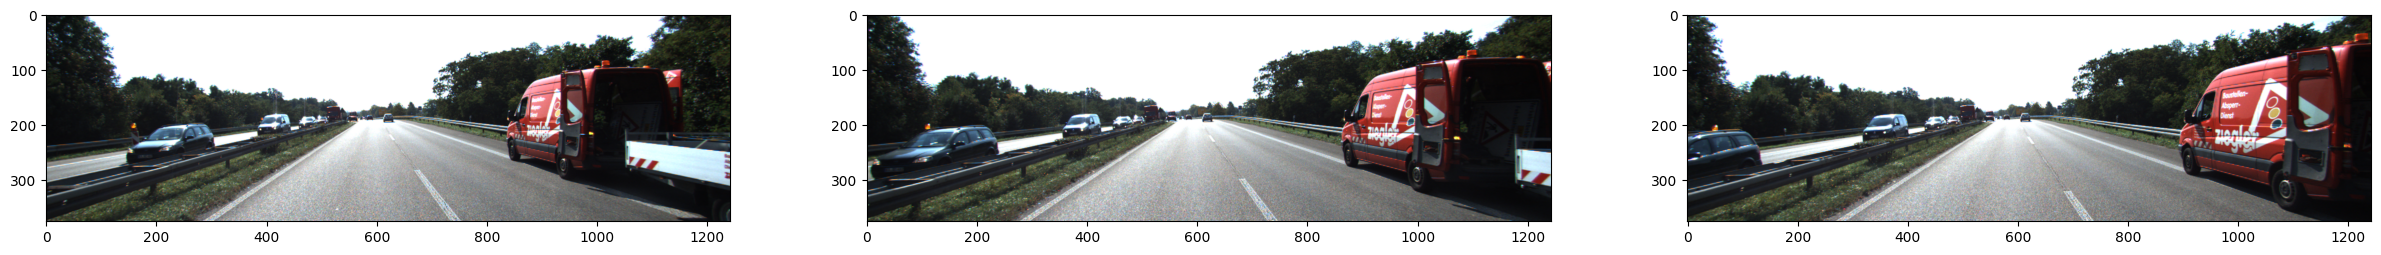

In [29]:
def view_images(images_to_be_shown):
  _, axs = plt.subplots(1, len(images_to_be_shown), figsize=(30, 30))

  if len(images_to_be_shown)> 1:
    axs = axs.flatten()
    for img, ax in zip(images_to_be_shown, axs):
      img_data = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax.imshow(img_data)
  else:
      img_data = cv2.cvtColor(images_to_be_shown[0], cv2.COLOR_BGR2RGB)
      axs.imshow(img_data)

  plt.show()

hand_picked_frames = [0, 1, 2]
images_2d = [dataset[i][3] for i in hand_picked_frames]
view_images(images_2d)

## **Chapter IV** - 3D Tracking 💣
The entire sequence will happen as follows, for each file, after we ran object detection:

1. **Predict the next position**
2. **Associate the boxes**
3. **Update the position**


### Initialization

**Imports related to 3D Tracking**

In [30]:
# type: ignore
from multi_object_tracking.tracker.box_op import convert_bbs_type, register_bbs
import numpy as np
from multi_object_tracking.tracker.object import Object

**Create a Tracker3D Class**

In [31]:
class Tracker3D:
    def __init__(self):
        self.current_timestamp = None
        self.current_pose = None
        self.current_bbs = None
        self.box_type = "Kitti" #Available box type "OpenPCDet", "Kitti", "Waymo"
        self.next_id = 0
        self.active_trajectories = {}
        self.dead_trajectories = {}

tracker = Tracker3D()

The Tracker3D will have several functions:

1. ✅ **```tracker = Tracker3D()```**: Initialize a tracker object.

2. **```tracker.predict_trajectories()```**: This function will build trajectories for each objects and predict their next positions.
3. **```tracker.associate()```** and **```tracker.create_cost_map()```**: These functions will help in association at a large scale (several boxes at t-1 vs several boxes at t).

4. **```tracker.update_trajectories()```**: This will update the trajectory using the Kalman Filter update.


At each step, we will do the following:
```python
    # for each bounding box, predict:
        tracker.objects = objects
        tracker.predict_trajectories()

    # For each predicted box, associate
        ids = tracker.association()

    # For each tracked box, update
    tracker.update_trajectories()

```

### Prediction
In order to predict a trajectory, we'll need to create an **Obstacle3D() class**, that will handle the Kalman Filter in 3D.

**Global Variables**

In [32]:
LIDAR_SCANNING_FREQUENCY = 10 #In Hz
TRACKING_LATENCY = 0 #in seconds | -1 = Global | 0-500 = Online or Near-Online

**Obstacle3D Class**<p>
What we're doing here is creating an object for each obstacle, and each object has its own Kalman Filter. We'll therefore implement 2 functions:
* **init_kf()** will initialize the Kalman Filter overall parameters (F, R, S, Q, ...)
* **init_trajectory()** will initialize the Kalman Filter's state and uncertainty

We will later add 2 other functions:
* **predict()**
* **update()**

In [33]:
class Obstacle3D:
    def __init__(self,init_bb=None,init_score=None,init_timestamp=None,label=None):
        assert init_bb is not None
        self.init_bb = init_bb
        self.init_score = init_score
        self.init_timestamp = init_timestamp
        self.label = label
        self.dt = 1./LIDAR_SCANNING_FREQUENCY
        self.trajectory = {}
        self.init_kf()
        self.init_trajectory()
        self.consecutive_missed_num = 0
        self.first_updated_timestamp = init_timestamp
        self.last_updated_timestamp = init_timestamp

    def __len__(self):
        return len(self.trajectory)

    def init_kf(self):
        STATE_FUNC_COVARIANCE =  100
        MEASURE_FUNC_COVARIANCE = 0.001

        # State Transition Matrix F (with 0s)
        self.F = np.mat(np.eye(9))

        # Process Noise Q
        self.Q = np.mat(np.eye(9))*STATE_FUNC_COVARIANCE

        # Measurement Noise
        self.R = np.mat(np.eye(3))*MEASURE_FUNC_COVARIANCE

        # Mapping Matrix / Measurement Function
        self.H = np.mat(np.zeros(shape=(3,9)))
        self.H[0:3,:] = self.F[0:3,:]

        # State Transition Matrix F (filled with constant acceleration model)
        self.F[0:3,3:6] = np.mat(np.eye(3))*self.dt #Position XYZ
        self.F[3:6,6:9] = np.mat(np.eye(3))*self.dt # Velocity XYZ
        self.F[0:3,6:9] = np.mat(np.eye(3))*0.5*self.dt**2 # Acc XYZ

        # Kalman Gain
        self.K = np.mat(np.zeros(shape=(9,9)))
        self.K[3, 0] = self.dt
        self.K[4, 1] = self.dt
        self.K[5, 2] = self.dt

    def init_trajectory(self):
        # Create a new Object instance
        object = Object()

        # Initialize detected state based on the initial bounding box (init_bb)
        detected_state = np.zeros(shape=(3))
        detected_state[:3] = self.init_bb[:3]
        detected_state = np.mat(detected_state).T
        object.detected_state = detected_state

        # Set predicted and updated state to the same value
        object.predicted_state = object.updated_state = self.H.T * detected_state

        # Initialize the covariance matrices
        update_covariance = np.mat(np.eye(9) * 0.01)
        object.updated_covariance = object.predicted_covariance = update_covariance.T

        # Set prediction score and initial score
        object.prediction_score = 1
        object.score = self.init_score

        # Add the object to the trajectory dictionary with the initial timestamp as the key
        self.trajectory[self.init_timestamp] = object

**Kalman Filter Predict**

In [34]:
def state_prediction(self,timestamp):
        # Decay factor for prediction score
        PREDICTION_SCORE_DECAY = 0.03

        # Get the previous timestamp
        previous_timestamp = timestamp-1

        # Check that the previous timestamp exists in the trajectory
        assert previous_timestamp in self.trajectory.keys()

        # Get the previous object
        previous_object = self.trajectory[previous_timestamp]

        # Get the previous state and covariance
        if previous_object.updated_state is not None:
            previous_state = previous_object.updated_state
            previous_covariance = previous_object.updated_covariance
        else:
            previous_state = previous_object.predicted_state
            previous_covariance = previous_object.predicted_covariance

        # Get the previous prediction score
        previous_prediction_score = previous_object.prediction_score

        # Calculate the current prediction score based on the previous prediction score
        # and whether the previous state was updated
        if previous_timestamp in self.trajectory.keys():
            if self.trajectory[previous_timestamp].updated_state is not None:
                current_prediction_score = previous_prediction_score * (1 - PREDICTION_SCORE_DECAY*15)
            else:
                current_prediction_score = previous_prediction_score * (1 - PREDICTION_SCORE_DECAY)
        else:
            current_prediction_score = previous_prediction_score * (1 - PREDICTION_SCORE_DECAY)

        print(current_prediction_score)
        # KF Predict: Calculate the predicted state and covariance using the previous state and covariance
        current_predicted_state = self.F*previous_state
        current_predicted_covariance = self.F*previous_covariance*self.F.T + self.Q

        # Create a new object to store the predicted state, predicted covariance, and prediction score
        new_ob = Object()
        new_ob.predicted_state = current_predicted_state
        new_ob.predicted_covariance = current_predicted_covariance
        new_ob.prediction_score = current_prediction_score

        # Add the new object to the trajectory and update the consecutive missed count
        self.trajectory[timestamp] = new_ob
        self.consecutive_missed_num += 1

Obstacle3D.state_prediction = state_prediction

In [35]:
test_score = 1
print(test_score * (1-0.03*15))
print(test_score*(1-0.03))

0.55
0.97


**Now, at the global level, we predict for every obstacle**

In [36]:
def predict_trajectories(self):
    # Maximum allowed number of consecutive missed predictions before a trajectory is considered dead
    MAX_PREDICTION_NUM = 12

    # Minimum trajectory length required for a new object (with only one detection) to be considered dead
    MAX_PREDICTION_NUM_FOR_NEW_OBJECT = 2

    # If there are no active trajectories, return immediately
    if len(self.active_trajectories) == 0 :
        return

    else:
        # A list to store the IDs of dead trajectories
        dead_track_id = []

        # Iterate through all keys (trajectory IDs) in the active_trajectories dictionary
        for key in self.active_trajectories.keys():
            # If a trajectory has consecutive missed predictions >= MAX_PREDICTION_NUM, mark it as dead
            if self.active_trajectories[key].consecutive_missed_num>=MAX_PREDICTION_NUM:
                dead_track_id.append(key)
                continue

            # If a trajectory has only one successful detection and its length >= MAX_PREDICTION_NUM_FOR_NEW_OBJECT,
            # mark it as dead
            if len(self.active_trajectories[key])-self.active_trajectories[key].consecutive_missed_num == 1 \
                and len(self.active_trajectories[key])>= MAX_PREDICTION_NUM_FOR_NEW_OBJECT :
                dead_track_id.append(key)
                continue

            # Predict the state of the trajectory based on the current timestamp
            self.active_trajectories[key].state_prediction(self.current_timestamp)

        # Move dead trajectories from active_trajectories to dead_trajectories
        for id in dead_track_id:
            tra = self.active_trajectories.pop(id)
            self.dead_trajectories[id]=tra

Tracker3D.predict_trajectories=predict_trajectories

### 3D Box Matching / Association
The association part will be done on the tracker side only, we will create 2 functions:
* **compute_cost_map()** to generate a cost map between boxes (t-1) and (t)
* **associate()** to implement this function, attribute the IDs, etc...

**Cost Map Generation**<p>
The cost map generation is going to work with a simple Euclidean Distance... but not only!

We'll also use the Kalman Filter Range Expansion to multiply this distance with the prediction score.<p>
When we miss detections, our confidence in the prediction will decrease, and therefore we will increase this search range.

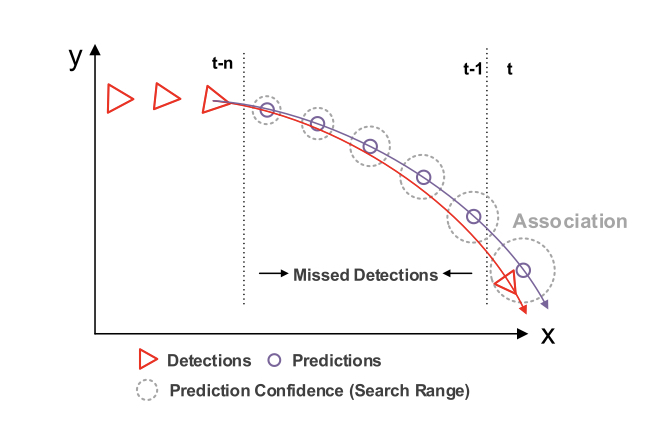

In [37]:
def compute_cost_map(self):
    # Initialize empty lists to store IDs, predictions, and detections
    all_ids = []
    all_predictions = []
    all_detections = []

    # Loop over all active trajectories
    for key in self.active_trajectories.keys():
        print("New Trajectory Tested")
        # Get the ID of the trajectory
        all_ids.append(key)
        # Get the predicted state and prediction score of the trajectory at the current timestamp
        state = np.array(self.active_trajectories[key].trajectory[self.current_timestamp].predicted_state)
        print(state)
        state = state.reshape(-1)
        pred_score = np.array([self.active_trajectories[key].trajectory[self.current_timestamp].prediction_score])
        print(pred_score)
        # Concatenate the predicted state and prediction score into a single array
        state = np.concatenate([state,pred_score])
        print(state)

        # Append the array to the all_predictions list
        all_predictions.append(state)

    # Loop over all current bounding boxes and scores
    for i in range(len(self.current_bbs)):
        # Create a new trajectory object using the current bounding box, score, timestamp, and label
        box = self.current_bbs[i]
        score = self.current_scores[i]
        label=1
        new_tra = Obstacle3D(init_bb=box,
                             init_score=score,
                             init_timestamp=self.current_timestamp,
                             label=label)

        # Get the predicted state of the new trajectory at the current timestamp
        state = new_tra.trajectory[self.current_timestamp].predicted_state
        state = state.reshape(-1)

        # Append the predicted state to the all_detections list
        all_detections.append(state)

    # Convert the all_detections and all_predictions lists into numpy arrays
    all_detections = np.array(all_detections)
    all_predictions = np.array(all_predictions)
    print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    print(all_detections.shape)
    print(all_predictions.shape)
    print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")

    # Reshape the all_detections and all_predictions arrays to prepare for broadcasting
    det_len = len(all_detections)
    pred_len = len(all_predictions)
    all_detections = all_detections.reshape((det_len,1,-1))
    all_predictions = all_predictions.reshape((1,pred_len,-1))

    # Use np.tile to create copies of the all_detections and all_predictions arrays to prepare for broadcasting
    all_detections = np.tile(all_detections,(1,pred_len,1))
    all_predictions = np.tile(all_predictions,(det_len,1,1))

    print("AFFFFFFFFFFFFFFFFFFFFFFFTER")
    print(all_detections.shape)
    print(all_predictions.shape)

    # Use broadcasting to calculate the Euclidean distance between all pairs of detections and predictions
    dis = (all_detections[...,0:3]-all_predictions[...,0:3])**2
    dis = np.sqrt(dis.sum(-1))

    # Calculate the cost for associating each detection with each prediction based on the Euclidean distance and the prediction score
    cost = dis*all_predictions[...,-1]

    # Return the cost map and the list of trajectory IDs
    return cost,all_ids

Tracker3D.compute_cost_map = compute_cost_map

**Association**

In [38]:
def association(self):
    # If there are no active trajectories, assign unique IDs to each detection
    if len(self.active_trajectories) == 0:
        ids = []
        for i in range(len(self.current_bbs)):
            ids.append(self.next_id)
            self.next_id+=1
        return ids

    # If there are active trajectories, use the cost map to assign IDs to each detection
    else:
        ids = []

        # Compute the cost map
        cost_map, all_ids = self.compute_cost_map()

        print(cost_map)
        # Loop over all current bounding boxes
        for i in range(len(self.current_bbs)):

            # Find the index of the minimum cost for the current detection
            min = np.min(cost_map[i])
            arg_min = np.argmin(cost_map[i])

            # If the minimum cost is below a certain threshold, assign the ID of the corresponding active trajectory
            if min<3.:
                ids.append(all_ids[arg_min])

                # Set the cost for the corresponding active trajectory to a very high value to prevent it from being assigned again
                cost_map[:,arg_min] = 100000

            # If the minimum cost is above the threshold, assign a new ID (new object)
            else:
                print("COST TOO HIGH: ", min)
                print("OBJECT NOT ASSOCIATED, ASSIGN NEW ID: ", self.next_id)
                ids.append(self.next_id)
                self.next_id+=1
        return ids

Tracker3D.association=association

### Trajectory Update
Similarly to predict, we will create 2 functions:
* **state_update()** in the Obstacle3D class
* **update_trajectories()** in the Tracker3D class to work at a global level (update all objects)

In [39]:
def sigmoid(self,x):
    return 1.0/(1+np.exp(-float(x)))

def state_update(self,bb=None,score=None,timestamp=None,):
    assert bb is not None
    assert timestamp in self.trajectory.keys()

    # Set the prediction score decay rate
    PREDICTION_SCORE_DECAY = 0.03

    # Create a template for the detected state using the bounding box coordinates
    detected_state = np.zeros(shape=(3))
    detected_state[:3] = bb[:3] #init x,y,z
    detected_state = np.mat(detected_state).T

    # Get the predicted state and covariance at the current timestamp
    current_ob = self.trajectory[timestamp]
    predicted_state = current_ob.predicted_state
    predicted_covariance = current_ob.predicted_covariance

    # Calculate the Kalman gain and update the state and covariance based on the detected state
    y = detected_state - self.H*predicted_state
    S = self.H*predicted_covariance*self.H.T+self.R
    KF_gain = predicted_covariance*self.H.T*S.I

    updated_state = predicted_state+KF_gain*y
    updated_covariance = (np.mat(np.eye(9)) - KF_gain*self.H)*predicted_covariance

    # If there are two consecutive timestamps with detected states, use the velocity to update the state
    if len(self.trajectory)==2:
        updated_state = self.H.T*detected_state+\
                        self.K*(self.H.T*detected_state-self.trajectory[timestamp-1].updated_state)

    # Update the trajectory object with the new state, covariance, detected state, and prediction score
    current_ob.updated_state = updated_state
    current_ob.updated_covariance = updated_covariance
    current_ob.detected_state = detected_state

    # Update the prediction score based on the detected score and the decay rate
    if self.consecutive_missed_num>1:
        current_ob.prediction_score = 1
    elif self.trajectory[timestamp - 1].updated_state is not None:
        current_ob.prediction_score = current_ob.prediction_score + PREDICTION_SCORE_DECAY*10*(self.sigmoid(score))
    else:
        current_ob.prediction_score = current_ob.prediction_score + PREDICTION_SCORE_DECAY*(self.sigmoid(score))
    current_ob.score = score
    print(current_ob.prediction_score)

    # Reset the consecutive missed detection counter and update the last updated timestamp
    self.consecutive_missed_num = 0
    self.last_updated_timestamp = timestamp

Obstacle3D.state_update = state_update
Obstacle3D.sigmoid = sigmoid

In [40]:
def update_trajectories(self,ids):
    # Set the score thresholds for initializing and updating trajectories
    INIT_SCORE = 0
    UPDATE_SCORE = 0

    # Ensure that the number of IDs matches the number of bounding boxes
    assert len(ids) == len(self.current_bbs)

    valid_bbs = []
    valid_ids = []

    # Loop over all bounding boxes and assigned IDs
    for i in range(len(self.current_bbs)):
        label = ids[i]
        box = self.current_bbs[i]
        score = self.current_scores[i]

        # If the assigned ID corresponds to an existing active trajectory and the score is above the update threshold, update the trajectory
        if label in self.active_trajectories.keys() and score>UPDATE_SCORE:
            track = self.active_trajectories[label]
            track.state_update(bb=box,score=score,timestamp=self.current_timestamp)
            valid_bbs.append(box)
            valid_ids.append(label)

        # If the score is above the initialization threshold, create a new trajectory with the assigned ID
        elif score>INIT_SCORE:
            new_tra = Obstacle3D(init_bb=box,
                                init_score=score,
                                init_timestamp=self.current_timestamp,
                                label=label)

            self.active_trajectories[label] = new_tra
            valid_bbs.append(box)
            valid_ids.append(label)

        # If the score is below both thresholds, ignore the bounding box
        else:
            continue

    # If no valid bounding boxes were found, return empty arrays
    if len(valid_bbs)==0:
        return np.zeros(shape=(0,7)),np.zeros(shape=(0))

    # Otherwise, return the valid bounding boxes and IDs as numpy arrays
    else:
        return np.array(valid_bbs),np.array(valid_ids)

Tracker3D.update_trajectories=update_trajectories

### Main Loop
Let's now implement the main loop and run our project!

**Initialization**

In [41]:
def init_all():
    Tracker3D.predict_trajectories = predict_trajectories
    Tracker3D.compute_cost_map = compute_cost_map
    Tracker3D.association = association
    Tracker3D.update_trajectories = update_trajectories
    Obstacle3D.state_prediction = state_prediction
    Obstacle3D.state_update = state_update

In [42]:
#hand_picked_frames = [0,1,2]
hand_picked_frames = range(len(dataset))
print(hand_picked_frames)

range(0, 390)


In [43]:
tracker=Tracker3D()
init_all()

**Loop**

In [44]:
all_time = 0
frame_num = 0

final_bbs = []
final_ids = []

for i in hand_picked_frames:
    # Run Object Detection and postprocessing
    #P2, V2C, points, image, objects, scores = dataset[i]
    P2,V2C,points,image,objects, objects_cam,det_scores, det_names, pose = dataset[i]
    # frame_id, pose, P2, V2C, points, image, objects, scores, label_names = dataset[i].values()

    mask = det_scores>4
    objects = objects_cam[mask]
    scores = det_scores[mask]
    # Initialize the Tracker
    start = time.time()
    tracker.current_bbs = objects[:,:7]
    tracker.current_scores = scores
    tracker.current_pose = pose
    tracker.current_timestamp = i

    # Kalman Filter: Predict
    tracker.predict_trajectories()
    if tracker.current_bbs is None:
        final_bbs.append(np.zeros(shape=(0,7)))
        final_ids.append(np.zeros(shape=(0)))
    else:
        if len(tracker.current_bbs) ==0:
            final_bbs.append(np.zeros(shape=(0,7)))
            final_ids.append(np.zeros(shape=(0)))
    # If Boxes, Associate them with t-1 & Kalman Filter: Update
        else:
            #if(tracker.current_bbs is not None) or (len(tracker.current_bbs) >0):
            tracker.current_bbs = convert_bbs_type(tracker.current_bbs,tracker.box_type) # For KITTI only
            tracker.current_bbs = register_bbs(tracker.current_bbs,tracker.current_pose)
            ids = tracker.association()
            bbs,ids = tracker.update_trajectories(ids)

            final_bbs.append(bbs)
            final_ids.append(ids.tolist())

    # Print or Visualize Output
    #print(np.array(bbs))
    #print(np.array(ids))

    end = time.time()
    all_time+=end-start
    frame_num+=1

0.55
0.55
0.55
New Trajectory Tested
[[-8.28629971]
 [ 2.11150002]
 [16.88355076]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[0.55]
[-8.28629971  2.11150002 16.88355076  0.          0.          0.
  0.          0.          0.          0.55      ]
New Trajectory Tested
[[-8.47770023]
 [ 2.13569999]
 [32.1317504 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[0.55]
[-8.47770023  2.13569999 32.1317504   0.          0.          0.
  0.          0.          0.          0.55      ]
New Trajectory Tested
[[-9.16450024]
 [ 2.49480009]
 [62.53585172]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[0.55]
[-9.16450024  2.49480009 62.53585172  0.          0.          0.
  0.          0.          0.          0.55      ]
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
(4, 1, 9)
(3, 10)
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AFFFFFFFFFFFFFFFFFFFFFFFTER
(4, 3, 

In [45]:
from pprint import pprint
pprint(final_ids)

[[0, 1, 2],
 [0, 1, 2, 3],
 [1, 2, 0],
 [1, 2],
 [1, 2, 4],
 [1, 2, 4],
 [1, 4, 2],
 [2, 4, 1],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [2, 4],
 [2],
 [2],
 [2],
 [2, 5],
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 [6],
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 [7],
 array([], dtype=float64),
 array([], dtype=float64),
 [8],
 [8],
 array([], dtype=float64),
 array([], dtype=float64),
 [9],
 array([], dtype=float64),
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtyp

**Visualization 3D**

In [ ]:
def visualize_tracking(dataset, hand_picked_frames, tracking=None, output_path=None, threshold=4):  
    rr.init("KITTI Visualizer 935", spawn=True)  

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )

    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

    # Store trajectories for visualization  
    trajectories = {}  # track_id -> list of center_3d positions  

    for idx, frame in enumerate(hand_picked_frames):
    # for i in frames:  
        rr.set_time_sequence("frame", frame)  
        rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/points", rr.Clear(recursive=False))
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/models", rr.Clear(recursive=True))
        # rr.log("world/ego_vehicle/lidar/trajectories", rr.Clear(recursive=True))  

        P2, V2C, points, image, objects, objects_cam, det_scores, det_names, pose = dataset[frame] 

        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  
              
            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),  
                relation=rr.TransformRelation.ParentFromChild,  
            ))

            # ===== ADD EGO VEHICLE MODEL =====
            rr.log(
                "world/ego_vehicle/lidar/car_model",
                rr.Asset3D(
                    path="4d-dataset/viewer/ego_car_fixed.glb",  # Path to your GLB file
                    albedo_factor = [1., 1., 1.]
                )
            )
        
        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        # Log point cloud with distance-based coloring  
        positions = points[:, :3]   
        colors = (plt.cm.cividis(np.linspace(0, 1, len(positions)))[:, :3] * 255).astype(np.uint8)  # Use a colormap for colors
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))  
        
        mask = det_scores > threshold        
        objects = objects_cam[mask]
        scores = det_scores[mask]
        ids = tracking[idx]
        names = np.array(det_names)[mask]

        centers, sizes, rotations, labels, color_ids = [], [], [], [], []  

        for object, id, name in zip(objects, ids, names):  
            h, w, l, x, y, z, ry, track_id = object.tolist() + [id]

            box_cam = np.array([h, w, l, x, y, z, ry])
            # 3D Camera Boxes
            corners_2d = project_3d_box_to_image(box_cam, P2)
            edges = [
                [0, 1], [1, 2], [2, 3], [3, 0],
                [4, 5], [5, 6], [6, 7], [7, 4],
                [0, 4], [1, 5], [2, 6], [3, 7]
            ]
            lines = [np.array([corners_2d[start], corners_2d[end]]) for start, end in edges]

            if l * w * h == 0:  # Skip invalid boxes  
                continue  

            # KITTI coordinate system: X=right, Y=down, Z=forward  
            # Rerun RIGHT_HAND_Z_UP: X=right, Y=forward, Z=up  
            center = np.array([z, -x, -y + h / 2])  # Transform KITTI to Rerun coordinates  
            size = np.array([l, w, h])    

            # Fix rotation: Ensure boxes are horizontal and properly oriented  
            # For horizontal boxes in the XY plane, we need to adjust the rotation  
            yaw = ry + np.pi / 2  # Adjust rotation to keep boxes horizontal  
            quat = R.from_euler('z', yaw, degrees=False).as_quat()  
            quat_rerun = np.array([quat[3], quat[0], quat[1], quat[2]])  # [w,x,y,z]

            # Generate unique color per track ID  
            color = np.array([  
                (37 * track_id) % 255,  
                (17 * track_id) % 255,  
                (91 * track_id) % 255,  
                255  
            ]).astype(np.uint8)

            rr.log(f"world/ego_vehicle/camera/image/detections/box_{track_id}", rr.LineStrips2D(lines, labels=[f"ID {track_id} {name}"], colors=np.array(color)))

            centers.append(center)  
            sizes.append(size)  
            rotations.append(quat)  
            labels.append(f"ID {int(track_id)}")  
            color_ids.append(color)  

            rr.log(f"world/ego_vehicle/lidar/models/car_{track_id}", rr.Transform3D(
                translation=center,
                quaternion=rr.Quaternion(xyzw=quat),
                scale=[0.4, 0.4, 0.4],
                relation=rr.TransformRelation.ParentFromChild,
            ))
            rr.log(f"world/ego_vehicle/lidar/models/car_{track_id}/model", rr.Asset3D(
                path="4d-dataset/viewer/car.obj",
                albedo_factor=color / 255.0
            ))

            # Store trajectory data with corrected coordinates  
            if track_id not in trajectories:  
                trajectories[track_id] = []  
            trajectories[track_id].append(center.copy())  

        # Log 3D boxes  
        if centers:  
            rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(  
                centers=np.array(centers),  
                half_sizes=np.array(sizes) / 2,  
                quaternions=np.array(rotations),  
                labels=labels,  
                colors=np.array(color_ids),  
            ))  

        # # Log trajectories with unique colors per track  
        # for track_id, trajectory in trajectories.items():  
        #     if len(trajectory) > 1:  
        #         # Only show trajectory up to current frame  
        #         # current_frame_trajectory = trajectory[:len([f for f in frames if f <= i])]  
        #         current_frame_trajectory = trajectory[:i + 1]  
        #         if len(current_frame_trajectory) > 1:  
        #             trajectory_points = np.array(current_frame_trajectory)  
                      
        #             # Generate the same unique color for this track ID as used for boxes  
        #             trajectory_color = np.array([  
        #                 (37 * track_id) % 255,  
        #                 (17 * track_id) % 255,  
        #                 (91 * track_id) % 255,  
        #                 180  # Alpha for transparency  
        #             ]).astype(np.uint8)  
                      
        #             # Create trajectory line with unique color  
        #             rr.log(  
        #                 f"world/ego_vehicle/lidar/trajectories/track_{track_id}",  
        #                 rr.LineStrips3D([trajectory_points], colors=[trajectory_color])  
        #             )  

        #             # Mark trajectory points with the same color  
        #             rr.log(  
        #                 f"world/ego_vehicle/lidar/trajectories/track_{track_id}/points",  
        #                 rr.Points3D(trajectory_points, colors=[trajectory_color], radii=[0.1])  
        #             )  

    rr.save(output_path, default_blueprint=blueprint)  
    print(f"Tracking visualization saved. Run:\nrerun {output_path}")

visualize_tracking(dataset, hand_picked_frames, tracking=final_ids, output_path="output/ego_tracking_final.rerun" )

[2025-08-26T23:23:03Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-08-26T23:23:03Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-26T23:23:03Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-26T23:23:03Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2025-08-26T23:23:04Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-26T23:23:04Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-26T23:23:04Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-26T23:23:04Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000
[2025-08-26T23:23:04Z WARN  wgpu_hal::vulkan::conv] Unrecognized present mode 1000361000


Tracking visualization saved. Run:
rerun output/ego_tracking_final.rerun
